# Встановлення необхідних бібліотек

In [ ]:
!pip install --quiet datasets
!pip install --quiet spacy
!python -m spacy download en_core_web_sm
!pip install pystemmer
!pip install transformers

     |████████████████████████████████| 194kB 17.1MB/s 
     |████████████████████████████████| 112kB 48.1MB/s 
     |████████████████████████████████| 245kB 51.2MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 563kB 18.7MB/s 
  Created wheel for pystemmer: filename=PyStemmer-2.0.1-cp37-cp37m-linux_x86_64.whl size=424785 sha256=491fdf919bb7b400a504be21af43a71c75921c9b0f241371be31b7dda1a9fc33
  Stored in directory: /root/.cache/pip/wheels/f3/3c/11/ee323a09706e17a649c2730bd8819b06e887411ff7507acf7a
Successfully built pystemmer
     |████████████████████████████████| 2.1MB 24.7MB/s 
     |████████████████████████████████| 870kB 50.1MB/s 
     |████████████████████████████████| 3.3MB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=1fbbbe372e17d0e47d9e38288e26455100f270126e8fe2017fae2ef3134723cb
  Stored in directory: /root/.cache/pip/whee

# Імпорт необхідних бібліотек

In [ ]:
import pandas as pd
import numpy as np
import spacy
import Stemmer
import transformers

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score

# Зчитування датасету


Набір даних відгуків Amazon. Дані охоплюють 18 років, включаючи ~ 35 мільйонів відгуків. 
Датасет складається із 3 колонок: 
  - content - рядок, що містить тіло документа
  - label - або 1 (позитивна), або 0 (негативна) оцінка (оцінка 1 та 2 як негативна, а 4 та 5 як позитивна, оцінки 3 ігноруються)
  - title - рядок, що містить заголовок рецензії

В своїй роботі я використовую лише 20000 записів, бо з більшою кількістю виникають проблеми при опрацюванні



In [ ]:
dataset = load_dataset("amazon_polarity")
df = pd.DataFrame.from_dict(dataset['train'])
remove_n = 3580000
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
sum(df_subset['label'])/len(df_subset['label'])

Reusing dataset amazon_polarity (/root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/35b3f5f426863b55dda2d5dc0da2d3714c7b0e5ba64bc4f1415ac9291ffdb234)


0.49885

In [ ]:
df_subset.to_csv('data.csv')

In [ ]:
len(df_subset['label'])

20000

In [ ]:
df_subset.head()

,content,label,title
57,Either 1 or 5 Stars. Depends on how you look a...,0,Either 1 or 5 Stars. Depends on how you look a...
659,this product is awesome. it hide all your secr...,1,very good
880,The classic book that is read by virtually eve...,1,a book value
1028,"Buy this album, and go ahead and buy el cielo ...",1,Best Album I Have Ever Heard. PERIOD !!!
1141,I bought this adapter for my 12-inch G4 powerb...,0,"Don't buy if you have a 12"" G4 Powerbook"


In [ ]:
df_subset = pd.read_csv('/content/data.csv')

# Поділ датасету на тренуальний і тестовий

70 відсотків даних до тренувального, 30 до тестового

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_subset['content'], df_subset['label'], test_size=0.3, random_state=42)

# Оголошення всіх необхідних функцій для препроцесінгу та тренування

- tokenize - для токенізації 
- remove_stop_words - для видалення стоп слів
- stem - для стемінгу
- preprocess - збирає tokenize, remove_stop_words та stem в одну вункцію
- create_vocab - для створення словника
- bag_of_words - повертає масив розміру словника із кількість входження кожного слова
- train - для тренування та визначення точності моделі 

In [ ]:
spacy_en = spacy.load("en_core_web_sm")
disable = ["ner", "parser", "tagger", "lemmatizer", "tok2vec", "senter", "attribute_ruler"]
stemmer = Stemmer.Stemmer("english")

In [ ]:
def tokenize(text):
  tokens = spacy_en(text, disable=disable)
  return tokens


def remove_stop_words(tokens):
  return [str(token) for token in tokens if str(token).lower() not in STOP_WORDS]


def stem(tokens):
  tokens = [token.lower() for token in tokens]
  return stemmer.stemWords(tokens)


def preprocess(text):
  tokens = tokenize(text)
  tokens = remove_stop_words(tokens)
  tokens = stem(tokens)
  return tokens


def create_vocab(all_tokens, vocab_size):
  token_counts = Counter(all_tokens)
  token_counts = token_counts.most_common()[:vocab_size]
  vocab_list = ['<UNK>'] + [token for token, _ in token_counts]
  return vocab_list


def bag_of_words(tokens, vocab):
  result = [0] * len(vocab)
  for t in tokens:
    if t not in vocab_list:
      t = '<UNK>'
    result[vocab_list.index(t)] += 1
  return result


def train(model, x_train, y_train, x_test, y_test):
  model.fit(x_train, y_train)
  print(model.score(x_test, y_test))

# Препроцесінг тренувальних даних, створення словника розміром 5000 та перетворення тренувальних даних у bag_of_words

In [ ]:
tokens_train = []

for doc in X_train:
  tokens_train.append(preprocess(doc))

vocab_list = create_vocab(list(chain.from_iterable(tokens_train)), 5000)
bag_of_words_train = []
for token in tokens_train:
  bag_of_words_train.append(bag_of_words(token, vocab_list))


# Препроцесінг тестових даних та перетворення тестових даних у bag_of_words

In [ ]:
tokens_test = []

for doc in X_test:
  tokens_test.append(preprocess(doc))

bag_of_words_test = []
for token in tokens_test:
  bag_of_words_test.append(bag_of_words(token, vocab_list))

# Тренування LogisticRegression, GaussianNB та LinearSVC на bag_of_words_train

In [ ]:
train(LogisticRegression(solver='liblinear', C=0.3, penalty="l1"),
      bag_of_words_train, y_train, bag_of_words_test, y_test)

0.8196666666666667


In [ ]:
train(GaussianNB(),
      bag_of_words_train, y_train, bag_of_words_test, y_test)

0.6796666666666666


In [ ]:
train(LinearSVC(C=0.005),
      bag_of_words_train, y_train, bag_of_words_test, y_test)

0.821


# Перетворення тренувальних та тестувальних даних за допомогою tf-idf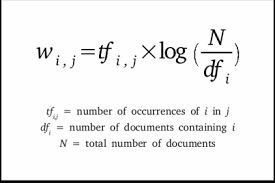

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)

# Тренування LogisticRegression, GaussianNB та LinearSVC на tf-idf

In [ ]:
train(LogisticRegression(solver='liblinear', C=0.9, penalty="l1"),
      tfidf_train.todense(), y_train, tfidf_test.todense(), y_test)

0.8191666666666667


In [ ]:
train(GaussianNB(),
      tfidf_train.todense(), y_train, tfidf_test.todense(), y_test)

0.7216666666666667


In [ ]:
train(LinearSVC(C=0.1),
      tfidf_train.todense(), y_train, tfidf_test.todense(), y_test)

0.8301666666666667


# Перетворення тренувальних та тестових даних в glove вектори

In [ ]:
glove = KeyedVectors.load("http://134.209.248.229:8081/glove-50k.bin")

doc_vector_train = []
doc_vector_test = []

for doc in X_train:
  tokens = [str(token).lower() for token in tokenize(doc) if str(token).lower() in glove]
  doc_vector_train.append(np.array(glove[tokens]).mean(axis=0))

for doc in X_test:
  tokens = [str(token).lower() for token in tokenize(doc) if str(token).lower() in glove]
  doc_vector_test.append(np.array(glove[tokens]).mean(axis=0))

# Тренування LogisticRegression, GaussianNB та LinearSVC на glove векторах

In [ ]:
train(LogisticRegression(solver='liblinear'),
      doc_vector_train, y_train, doc_vector_test, y_test)

0.7883333333333333


In [ ]:
train(GaussianNB(),
      doc_vector_train, y_train, doc_vector_test, y_test)

0.6735


In [ ]:
train(LinearSVC(C=0.9),
      doc_vector_train, y_train, doc_vector_test, y_test)

0.7951666666666667


# Завантаження токенайзера та моделі Берт

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert = transformers.AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

# Токенізація одного відсотка датасету 

In [ ]:
def tokenize(batch):
  return tokenizer(batch['content'], padding=True, truncation=True)

train_data, test_data = load_dataset('amazon_polarity', split=['train[:1%]', 'test[:1%]'])

train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
test_data = test_data.map(tokenize, batched=True, batch_size=len(test_data))

Dataset amazon_polarity downloaded and prepared to /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/35b3f5f426863b55dda2d5dc0da2d3714c7b0e5ba64bc4f1415ac9291ffdb234. Subsequent calls will reuse this data.


# Визначення функції обрахунку метрики точності

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc
  }

# Тренування моделі Берт з:
 - темпом навчання - 2е-5
 - розміром батчів - 20
 - кількістю епох - 1
 - метрикою - accuracy 

In [ ]:
args = transformers.TrainingArguments(
    output_dir='./output',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

trainer = transformers.Trainer(
    model = bert,
    args = args,
    compute_metrics=compute_metrics,
    train_dataset=train_data, 
    eval_dataset=test_data
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.207700,0.200203,0.928250,38.683200,103.404000


TrainOutput(global_step=1800, training_loss=0.2353364372253418, metrics={'train_runtime': 1220.7125, 'train_samples_per_second': 1.475, 'total_flos': 4844864523600000.0, 'epoch': 1.0, 'init_mem_cpu_alloc_delta': 1624104960, 'init_mem_gpu_alloc_delta': 268953088, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 353222656, 'train_mem_gpu_alloc_delta': 1077682176, 'train_mem_cpu_peaked_delta': 126976, 'train_mem_gpu_peaked_delta': 4002861568})

# Тренування моделі Берт з:
 - темпом навчання - 2е-5
 - розміром батчів - 20
 - кількістю епох - 2
 - метрикою - accuracy 

In [ ]:
args = transformers.TrainingArguments(
    output_dir='./output',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

trainer = transformers.Trainer(
    model = bert,
    args = args,
    compute_metrics=compute_metrics,
    train_dataset=train_data, 
    eval_dataset=test_data
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.212300,0.201466,0.928500,39.237800,101.943000
2,0.126300,0.241159,0.929750,39.220300,101.988000


TrainOutput(global_step=3600, training_loss=0.1844108732541402, metrics={'train_runtime': 2483.4699, 'train_samples_per_second': 1.45, 'total_flos': 9689729047200000.0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 1647521792, 'init_mem_gpu_alloc_delta': 268953088, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 355926016, 'train_mem_gpu_alloc_delta': 1077682176, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 4006168064})